# How to build a simple ReAct AI Agentic application for everyday DevOps tasks using REST APIs

This notebook demonstrates how to create a simple ReAct AI agent application that performs simple tasks such as retrieving GitHub repo descriptions or labels through standard REST APIs. The app uses LangGraph to define the agentic workflow. We'll also showcase how the ReAct (Reasoning and Acting) framework lets the agent decide when and how to use tools effectively.

![](docs/ai-agent.svg)

The workflow follows a loop in which the agent reasons whether to call the tools and if so, the tools are executed. The results are fed back to the agent for further decision-making.

The process works like this:

- Step 1: Interact with the app, prompting the agent (LLM) to decide whether it should use a tool like GitHub API.
- Step 2: If the agent recommends taking an action (e.g., using the tool), it calls the API and retrieves results.
- Step 3: The agent evaluates the results, and either takes further action or provides a final response.

Let's walk through the components depicted in the diagram.

## Understanding the Components:

1. **FastAPI Server:** This server acts as the entry point for HTTP requests. We will use the command-line curl utility to test our AI Agent FastAPI server.
2. **LangGraph State Machine:** At the core of our sample application is the LangGraph state machine, which maintains the workflow for interacting with multiple agents and tools. LangGraph defines the workflow and ensures the state is managed correctly as the AI agent proceeds through its reasoning steps.
3. **Agent (LLM Calls):** The AI agent, powered by a Large Language Model (LLM), makes decisions based on the input provided. The agent is central to the ReAct (Reasoning and Acting) architecture, where it continuously evaluates its actions, deciding whether it needs to call a particular tool, like make a GitHub API request or return the final answer to the user.
4. **Tools Integration:** The agent uses various tools to fulfill its tasks. For instance, when tasked with fetching data about a GitHub repository description, the agent invokes the GitHub API as one of its "tools.”


## Code Implementation
Here is the code implementation for building a simple ReAct AI agent to retrieve information from GitHub repositories using the GitHub API. The application uses FastAPI to interact with external clients, LangGraph to manage workflows, and a Large Language Model (LLM) to reason and make decisions.

_Code Disclaimer:_ The code provided in this blog is for educational and informational purposes only. While every effort is made to ensure the code is functional and accurate, it is provided "as-is" without any guarantees. Use the code at your own risk. The author is not responsible for any damage or data loss caused by implementing the code. Always review and test code in a safe environment before using it in production.

### 1. Setting Up the Environment

- Python3 and pip are prerequisites for proceeding. 
- Create Python virtual env

```
python -m venv venv
source venv/bin/activate
```

- Install the python packages

In [21]:
!pip install fastapi[standard] langgraph langchain_openai langchain_core langserve[server] requests ipykernel


[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: pip install --upgrade pip


### 2. Create the necessary tools for the Agent to invoke based on input
In this section, we create the tools that the agents will invoke based on their reasoning. 

In [22]:
from langchain_core.tools import tool
import requests

Define a function call to get github repo description based on repo name and github org name

In [23]:
# Define tools
@tool
def get_github_repo_description(repo_name: str, org_name: str) -> str:
  """
  Fetches the description of a GitHub repository.

  Args:
  repo_name (str): The name of the repository.
  org_name (str): The name of the organization or user that owns the repository.

  Returns:
  str: The description of the repository if available, otherwise a message indicating
      that no description is available or an error message if the request fails.

  Raises:
  requests.exceptions.RequestException: If there is an issue with the HTTP request.
  """
  url = f"https://api.github.com/repos/{org_name}/{repo_name}"
  headers = {
    "Authorization": f"token {os.getenv('GITHUB_TOKEN')}"
  }
  response = requests.get(url, headers=headers)
  if response.status_code == 200:
    repo_info = response.json()
    return repo_info['description'] if repo_info['description'] else f"No description available for {repo_name} in {org_name}"
  else:
    return f"Failed to fetch description for {repo_name} in {org_name}. Status code: {response.status_code}"

Define a function call to get github repo topics based on repo name and github org name

In [24]:
@tool
def get_github_repo_topics(repo_name: str, org_name: str) -> str:
  """
  Fetches the topics of a GitHub repository.

  Args:
  repo_name (str): The name of the repository.
  org_name (str): The name of the organization or user that owns the repository.

  Returns:
  str: A comma-separated string of topics if available, otherwise a message indicating
      that no topics are available or an error message if the request fails.

  Raises:
  requests.exceptions.RequestException: If there is an issue with the HTTP request.
  """
  url = f"https://api.github.com/repos/{org_name}/{repo_name}/topics"
  headers = {
    "Authorization": f"token {os.getenv('GITHUB_TOKEN')}",
    "Accept": "application/vnd.github.mercy-preview+json"
  }
  response = requests.get(url, headers=headers)
  if response.status_code == 200:
    repo_info = response.json()
    topics = repo_info.get('names', [])
    return ", ".join(topics) if topics else f"No topics available for {repo_name} in {org_name}"
  else:
    return f"Failed to fetch topics for {repo_name} in {org_name}. Status code: {response.status_code}"


In [25]:
import os

os.environ["LLM_MODEL_NAME"] = "openai"
os.environ["OPENAI_MODEL"] = "gpt-4o"

**Ask for user input to get OPENAI_API_KEY**

In [26]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")

**Ask for user input to get GITHUB_TOKEN**

In [27]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("GITHUB_TOKEN")

### 3. Define the SimpleAIAgent Python Class
In this section, we define the SimpleAIClass class, which powers our agent's reasoning capabilities. Based on the environment variable, the user can choose to either use OpenAI or Azure OpenAI. Default is OpenAI


In [28]:
from langchain_openai import ChatOpenAI, AzureChatOpenAI
from langgraph.graph import MessagesState
from langchain_core.messages import HumanMessage, SystemMessage
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition, ToolNode
from langgraph.checkpoint.memory import MemorySaver
import datetime
import json

In [29]:
class SimpleAIAgent():
  '''
  Simple AI Agent is a class that initializes and configures an AI assistant using LLMs.
  '''
  def __init__(self, thread_id: str):
    # Specify a thread
    self.config = {"configurable": {"thread_id": thread_id}}

    # Initialize LLMFactory with the desired model name
    model_name = os.getenv("LLM_MODEL_NAME", "openai")

    if model_name == "azure_openai":
      deployment = os.getenv("AZURE_OPENAI_DEPLOYMENT")
      api_version = os.getenv("AZURE_OPENAI_API_VERSION")
      llm = AzureChatOpenAI(
        azure_deployment=deployment,
        api_version=api_version,
        temperature=0,
        max_tokens=None,
        timeout=None,
        max_retries=2
      )
    elif model_name == "openai":
      llm = ChatOpenAI(
        model=os.getenv("OPENAI_MODEL"),
        temperature=0,
        max_tokens=None,
        timeout=None,
        max_retries=2
      )

    tools = [
      get_github_repo_description,
      get_github_repo_topics
    ]

    llm_with_tools = llm.bind_tools(tools)

    # System message
    sys_msg = SystemMessage(content=(
      "You are a helpful Assistant tasked with performing tasks.\n"
      "You can assist with github repo operations \n"
    ), pretty_repr=True)

    # Node
    def assistant(state: MessagesState):
      return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

    # Graph
    self.builder = StateGraph(MessagesState)

    # Define nodes: They do the actual work
    self.builder.add_node("simple_ai_agent", assistant)
    self.builder.add_node("tools", ToolNode(tools))

    # Define edges: these determine how the control flow moves
    self.builder.add_edge(START, "simple_ai_agent")

    # Add conditional edges
    self.builder.add_conditional_edges(
      "simple_ai_agent",
      tools_condition,
      "tools"
    )

    # Add an edge to the tool node
    self.builder.add_edge("tools", "simple_ai_agent")

    checkpointer = MemorySaver()
    self.react_graph_memory = self.builder.compile(checkpointer=checkpointer)

    self.react_graph_memory = self.builder.compile(checkpointer=checkpointer)

  def interact(self, human_message:str):
    try:
      # Specify an input
      messages = [HumanMessage(content=human_message)]

      # return messages
      messages = self.react_graph_memory.invoke({"messages": messages}, self.config)

      # print messages
      for message in messages['messages']:
        print("-" * 80)
        print(f"Type: {type(message).__name__}, Content: {message.content}")
        if message.additional_kwargs and 'tool_calls' in message.additional_kwargs:
            print(f"Tool Call ID: {message.additional_kwargs['tool_calls'][0]['id']}, Name: {message.additional_kwargs['tool_calls'][0]['function']['name']}, Arguments: {message.additional_kwargs['tool_calls'][0]['function']['arguments']}")
        print("-" * 80)

      return messages['messages'][-1].content
    except Exception as e:
      print(e)

  def create_graph_image(self, write_to_file: bool = True):
    graph_image = self.react_graph_memory.get_graph(xray=1).draw_mermaid_png()
    if not write_to_file:
      return graph_image
    timestamp = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M_%S")
    filename = f"simple_ai_agent_{timestamp}.png"
    with open(filename, "wb") as f:
      f.write(graph_image)
    print(f"Graph image saved as '{filename}'. Open this file to view the graph.")

  def print_message_history(self, thread_id: str):
    message_history = [s for s in self.react_graph_memory.get_state_history(self.config)]
    print(f"Message history for thread_id {thread_id}: {json.dumps(message_history, default=str, indent=2)}")
    print(json.dumps(message_history, default=str, indent=2))

Let's generate an image of the graph to visualize our state machine

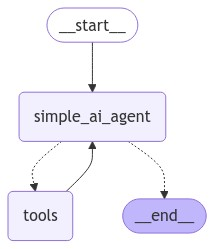

In [30]:
from IPython.display import Image, display

thread_id = "0"
display(Image(SimpleAIAgent(thread_id).create_graph_image(write_to_file=False)))

Create the ChatBotQuestion BaseModel

In [31]:
from pydantic import BaseModel

In [32]:
class ChatBotQuestion(BaseModel):
  question: str

In [33]:
import json
import uuid

Get `uuid` for thread_id

In [34]:
def get_uuid() -> str:
  unique_id = str(uuid.uuid4())
  print(f"Generated UUID: {unique_id}")
  return unique_id

In [35]:
from fastapi import FastAPI

In [36]:
# Initialize the SimpleAIAgent
agent = SimpleAIAgent(get_uuid())

app = FastAPI()

@app.post("/question")
def ask_question(question: ChatBotQuestion):
  """
  Interacts with a chatbot agent to ask a question and retrieve the response.

  Args:
    question (ChatBotQuestion): An object containing the question text and chat session ID.

  Returns:
    str: The content of the second message in the response from the chatbot agent.

  Note:
    The function returns the content of the message at index 1 because the response
    is expected to be a list of messages, where the first message (index 0) is a HumanMessages,
    and the second message is an AIMessage.
  """
  response = agent.interact(question.question)
  return str(response)

Generated UUID: 71a27770-b9ae-4488-8872-7ff714e795bd


Start FastAPI unicorn server

In [37]:
import asyncio
import uvicorn

In [20]:
config = uvicorn.Config(app, host="localhost", port=8000)
server = uvicorn.Server(config)
await server.serve()


INFO:     Started server process [34858]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://localhost:8000 (Press CTRL+C to quit)


--------------------------------------------------------------------------------
Type: HumanMessage, Content: check if the repo description has any maching topics in the repo topics in repo simple-ai-agent in sriaradhyula org
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Type: AIMessage, Content: 
Tool Call ID: call_wB0PnSDKwtG4v58iqb5pKi2b, Name: get_github_repo_description, Arguments: {"repo_name": "simple-ai-agent", "org_name": "sriaradhyula"}
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Type: ToolMessage, Content: This repo demonstrates building a simple ReAct AI agent to perform tasks such as retrieving GitHub repo details via REST APIs, using LangGraph to define workflows.
-------------------------------------------------------------------------------